# Exercise Sheet 2

### 2.2 Solving a PDE with TorchPhysics
Use TorchPhysics to solve the following heat equation:

\begin{align*}
{\partial_t} u(t,x) &= \Delta_x u(t,x) &&\text{ on } I \times \Omega, \\
u(0,x) &= u_0 &&\text{ on } \Omega,\\
u(t,x) &= h(t) &&\text{ at } I \times \partial \Omega_{heater}, \\
\nabla_x u(t,x) \cdot \overset{\rightarrow}{n}(x) &= 0 &&\text{ at } I \times (\partial \Omega \setminus \partial\Omega_{heater}).
\end{align*}

The above system describes an isolated room $\Omega$, with a \\
heater at the wall $\partial\Omega_{Heater} = \{(x, y) | 1\leq x\leq 3, y=4\}$. We set $I=[0, 20]$, $D=1$, the initial temperature to $u_0 = 16\degree C$ and the temperature of the heater is defined below.

If you are using Google Colab, you first have to install TorchPhysics with the following cell. We recommend first enabling the GPU and then running the cell. Since the installation can take around 2 minutes and has to be redone if you switch to the GPU later.

In [1]:
###!pip install torchphysics

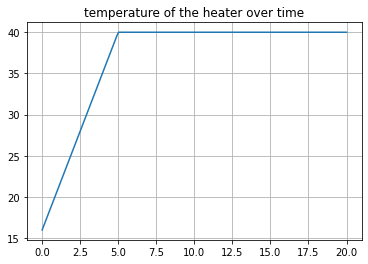

In [2]:
import torch
import torchphysics as tp
import pytorch_lightning as pl
import matplotlib.pyplot as plt

# Here all parameters are defined:
t_min, t_max = 0.0, 20.0 # time interval bounds
width, height = 5.0, 4.0 # the size of the room 
D = 1.0
u_0          = 16 # initial temperature
u_heater_max = 40 # maximal temperature of the heater
t_heater_max = 5  # time at which the heater reaches its maximal temperature

# Heater temperature function
def h(t):
    ht = u_0 + (u_heater_max - u_0) / t_heater_max * t
    ht[t>t_heater_max] = u_heater_max
    return ht

# Visualize h(t)
t = torch.linspace(0, 20, 200)
plt.plot(t, h(t))
plt.grid()
plt.title("temperature of the heater over time")

# Number of training points 
N_pde = 20000
N_initial = 5000
N_boundary = 10000

# Training parameters
train_iterations = 5000
learning_rate = 1.e-3

We would recommend trying implementing the following steps by yourself (and/or together with your colleagues). 

But if you need more guidance for TorchPhysics, a heat equation example is shown in this [notebook](https://github.com/TomF98/torchphysics/blob/main/examples/pinn/heat-equation.ipynb).

In [3]:
### TODO: Implement the spaces
X = tp.spaces.R2('x')
T = tp.spaces.R1('t')
U = tp.spaces.R1('u')

### TODO: Define the domain omega and time interval 
Omega = tp.domains.Parallelogram(space=X, origin=[0,0], corner_1=[width,0], corner_2=[0,height])
circle = tp.domains.Circle(X, [2, 2], 0.5)
Omega -= circle
I     = tp.domains.Interval(space=T, lower_bound=t_min, upper_bound=t_max)

### TODO: Create sampler for inside Omega x I, for the initial condition in Omega x {0} and on the 
###       boundary \partial Omega x I
pde_sampler = tp.samplers.RandomUniformSampler(domain=I*Omega, n_points=N_pde)
initial_sampler = tp.samplers.RandomUniformSampler(domain=I.boundary_left*Omega, n_points=N_initial)
boundary_sampler = tp.samplers.RandomUniformSampler(domain=I*Omega.boundary, n_points=N_boundary)

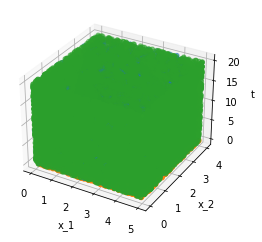

In [4]:
# One can check if the points are sampled in the correct way:
plot = tp.utils.scatter(Omega.space*I.space, pde_sampler, initial_sampler, boundary_sampler)
# Sometimes the perspective is somewhat strange in the plot, but generally one should see:
# - blue   = points inside the domain I x Omega
# - orange = points at the bottom, for {0} x Omega
# - green  = points at sides, for I x \partial Omega 

In [5]:
### TODO: Create the neural network with 4 hidden layers and 50 neurons each.
model = tp.models.FCN(input_space=T*X, output_space=U, hidden = (50,50,50,50))

In [6]:
### TODO: Define condition for the PDE:
# Use tp.utils.laplacian and tp.utils.grad to compute all needed derivatives
def pde_residual(u, t, x):
    return tp.utils.laplacian(u, x) - tp.utils.grad(u, t)

pde_condition = tp.conditions.PINNCondition(model, pde_sampler, pde_residual)

In [7]:
### TODO: Define condition for the initial temperature:
def initial_residual(u):
    return u - u_0

initial_condition = tp.conditions.PINNCondition(model, initial_sampler, initial_residual)

In [8]:
### TODO: Define condition for the boundary conditions:
###       Already implemented is a filltering, to determine on what part the points are
###       on the boundary, and the normal vector computation.
###       For the normal derivative use: tp.utils.normal_derivative
def boundary_residual(u, t, x):
    # Create boolean tensor indicating which points x belong to the dirichlet condition (heater location)
    heater_location = (x[:, 0] >= 1) & (x[:, 0] <= 3) & (x[:, 1] >= 3.99)   
    # Normal vectors of the domain Omega
    normal_vectors  = Omega.boundary.normal(x)

    residual = tp.utils.normal_derivative(u, normal_vectors, x)
    residual[heater_location] = (u - h(t))[heater_location]
    return residual

boundary_condition = tp.conditions.PINNCondition(model, boundary_sampler, boundary_residual)

In [9]:
# Start the training
training_conditions = [pde_condition, initial_condition, boundary_condition]
optim = tp.OptimizerSetting(optimizer_class=torch.optim.Adam, lr=learning_rate)
solver = tp.solver.Solver(train_conditions=training_conditions, optimizer_setting=optim)

trainer = pl.Trainer(gpus=1 if torch.cuda.is_available() else None,
                     max_steps=train_iterations, # number of training steps
                     logger=False,
                     benchmark=True)

trainer.fit(solver) # run the training loop

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name             | Type       | Params
------------------------------------------------
0 | train_conditions | ModuleList | 7.9 K 
1 | val_conditions   | ModuleList | 0     
------------------------------------------------
7.9 K     Trainable params
0         Non-trainable params
7.9 K     Total params
0.032     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

/home/tomfre/miniconda3/envs/bosch/lib/python3.9/site-packages/pytorch_lightning/utilities/distributed.py:69: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)
/home/tomfre/miniconda3/envs/bosch/lib/python3.9/site-packages/pytorch_lightning/utilities/distributed.py:69: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


Training: 0it [00:00, ?it/s]

/home/tomfre/miniconda3/envs/bosch/lib/python3.9/site-packages/torch/functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2895.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
/home/tomfre/Desktop/torchphysics/src/torchphysics/problem/domains/domain2D/parallelogram.py:134: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matricesor `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2985.)
  bary_coords = torch.stack(torch.meshgrid((x, y))).T.reshape(-1, 2)
/home/tomfre/Desktop/torchphysics/src/torchphysics/utils/plotting/plot_functions.py:416: UserWarning: Creating a tensor from a list of 

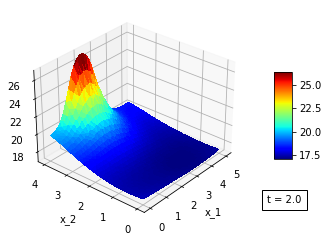

In [ ]:
# Plot the solution at some point in time
time_point = 2.0

plot_sampler = tp.samplers.PlotSampler(plot_domain=Omega, n_points=1000, 
                                       data_for_other_variables={'t':time_point}) # <- input that is fixed for the plot
fig = tp.utils.plot(model=model, plot_function=lambda u : u, point_sampler=plot_sampler, angle=[30, 220])

MovieWriter ffmpeg unavailable; using Pillow instead.


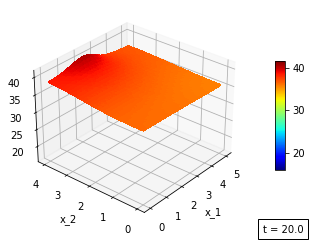

In [ ]:
# We can also animate the solution over time
anim_sampler = tp.samplers.AnimationSampler(Omega, I, 200, n_points=1000)
fig, anim = tp.utils.animate(model, lambda u: u, anim_sampler, ani_speed=10, angle=[30, 220])
anim.save('heat-eq.gif')
# On Google colab you have at the left side a tab with a folder. There you should find the gif and can watch it.

In [ ]:
# !wget https://github.com/TomF98/torchphysics/raw/main/examples/workshop/FEMData/Data2_2/time_points.pt
# !wget https://github.com/TomF98/torchphysics/raw/main/examples/workshop/FEMData/Data2_2/space_coords.pt
# !wget https://github.com/TomF98/torchphysics/raw/main/examples/workshop/FEMData/Data2_2/temperature.pt

In [ ]:
# We can compare the results with an finite element solution:
import numpy as np
fe_time = torch.load("FEMData/Data2_2/time_points.pt")
fe_space = torch.load("FEMData/Data2_2/space_coords.pt")
fe_temperature = torch.load("FEMData/Data2_2/temperature.pt")

in_data = torch.zeros((len(fe_time), len(fe_space), 3))
in_data[:, :, :2] = fe_space
in_data[:, :, 2] = fe_time.repeat(1, len(fe_space))

model_out = model(tp.spaces.Points(in_data, X*T))

error = torch.abs(model_out.as_tensor - fe_temperature)
print("Max. absolute error between FE and PINN:", torch.max(error))
print("Relative error is:", torch.max(error)/torch.max(fe_temperature))

torch.Size([41, 546, 1])
Max. absolute error between FE and PINN: tensor(7.1934, grad_fn=<MaxBackward1>)
Relative error is: tensor(0.1798, grad_fn=<DivBackward0>)


The error is generally around 15%. To further reduce it, we switch to a different optimization algorithm: LBFGS.
This optimizer uses also the hessian matrix, instead of only the gradient, for the optimization. One disadvantage is, that we have to fix the evaluation points for LBFGS to work.

In [ ]:
# Fix the points in our samplers with "make_static":
pde_condition.sampler = tp.samplers.RandomUniformSampler(Omega*I, n_points=50000).make_static()
initial_condition.sampler = tp.samplers.RandomUniformSampler(Omega*I.boundary_left, n_points=15000).make_static()
boundary_condition.sampler = tp.samplers.RandomUniformSampler(Omega.boundary*I, n_points=25000).make_static()

# Choose LBFGS
training_conditions = [pde_condition, initial_condition, boundary_condition]
optim = tp.OptimizerSetting(optimizer_class=torch.optim.LBFGS, lr=0.05, 
                            optimizer_args={'max_iter': 3})
solver = tp.solver.Solver(train_conditions=training_conditions, optimizer_setting=optim)

# Start training
trainer = pl.Trainer(gpus=1 if torch.cuda.is_available() else None,
                     max_steps=1500, # number of training steps
                     logger=False,
                     benchmark=True)

trainer.fit(solver) # run the training loop

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name             | Type       | Params
------------------------------------------------
0 | train_conditions | ModuleList | 7.9 K 
1 | val_conditions   | ModuleList | 0     
------------------------------------------------
7.9 K     Trainable params
0         Non-trainable params
7.9 K     Total params
0.032     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

/home/tomfre/miniconda3/envs/bosch/lib/python3.9/site-packages/pytorch_lightning/utilities/distributed.py:69: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)
/home/tomfre/miniconda3/envs/bosch/lib/python3.9/site-packages/pytorch_lightning/utilities/distributed.py:69: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

In [ ]:
# Lastly, we can again compare the results with an finite element solution:
import numpy as np
fe_time = torch.load("FEMData/Data2_2/time_points.pt")
fe_space = torch.load("FEMData/Data2_2/space_coords.pt")
fe_temperature = torch.load("FEMData/Data2_2/temperature.pt")

in_data = torch.zeros((len(fe_time), len(fe_space), 3))
in_data[:, :, :2] = fe_space
in_data[:, :, 2] = fe_time.repeat(1, len(fe_space))

model_out = model(tp.spaces.Points(in_data, X*T))

error = torch.abs(model_out.as_tensor - fe_temperature)
print("Max. absolute error between FE and PINN:", torch.max(error))
print("Relative error is:", torch.max(error)/torch.max(fe_temperature))
print("Should now be around 8%")

torch.Size([41, 546, 1])
Max. absolute error between FE and PINN: tensor(4.2623, grad_fn=<MaxBackward1>)
Relative error is: tensor(0.1066, grad_fn=<DivBackward0>)
